In [1]:
import json
import re
import os
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


In [2]:
#bar chart
def plot_total_matches(results_by_file):
    files = [os.path.splitext(os.path.basename(file))[0] for file in results_by_file.keys()]
    percentage_matches = [results['percentage_matches'] for results in results_by_file.values()]

    plt.figure(figsize=(10, 6))
    plt.bar(files, percentage_matches, color='skyblue')
    plt.xlabel('Files')
    plt.ylabel('Percentage of Reviews with Matches (%)')
    plt.title('Percentage of Recommendation Matches by File')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# heatmap
def plot_heatmap(results_by_file, patterns):
    files = [os.path.splitext(os.path.basename(file))[0] for file in results_by_file.keys()]
    pattern_counts = {pattern: [] for pattern in patterns}

    for file in results_by_file.keys():
        pattern_counts_file = {pattern: 0 for pattern in patterns}
        total_reviews = results_by_file[file]["total_reviews"]

        for detail in results_by_file[file]["detailed_results"]:
            for _, pattern in detail["matches"]:
                pattern_counts_file[pattern] += 1

        for pattern in patterns:
            percentage_match = (pattern_counts_file[pattern] / total_reviews) * 100 if total_reviews > 0 else 0
            pattern_counts[pattern].append(percentage_match)

    df = pd.DataFrame(pattern_counts, index=files)

    plt.figure(figsize=(12, 8))
    sns.heatmap(df, annot=True, cmap='YlGnBu', fmt='.2f', linewidths=.5)
    plt.title('Percentage of Recommendation Patterns by File')
    plt.xlabel('Patterns')
    plt.ylabel('Files')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()




Analyzing file: EMNLP2023
Total matches found in EMNLP2023: 315 (4.88% of reviews)

Analyzing file: NeurIPS2023
Total matches found in NeurIPS2023: 311 (2.05% of reviews)

Analyzing file: NeurIPS2024
Total matches found in NeurIPS2024: 289 (1.74% of reviews)

Analyzing file: ICLR2023
Total matches found in ICLR2023: 406 (2.83% of reviews)


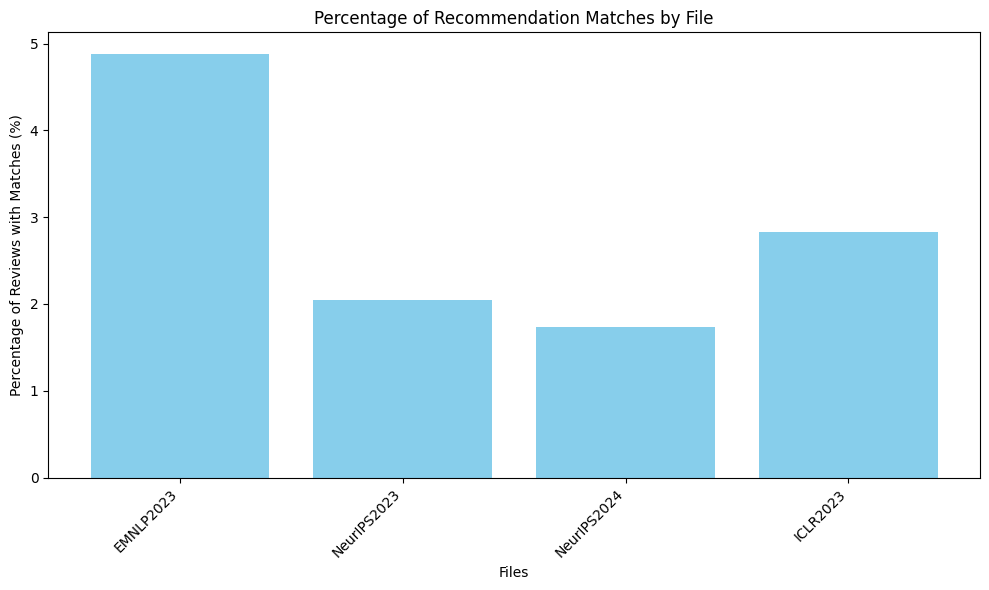

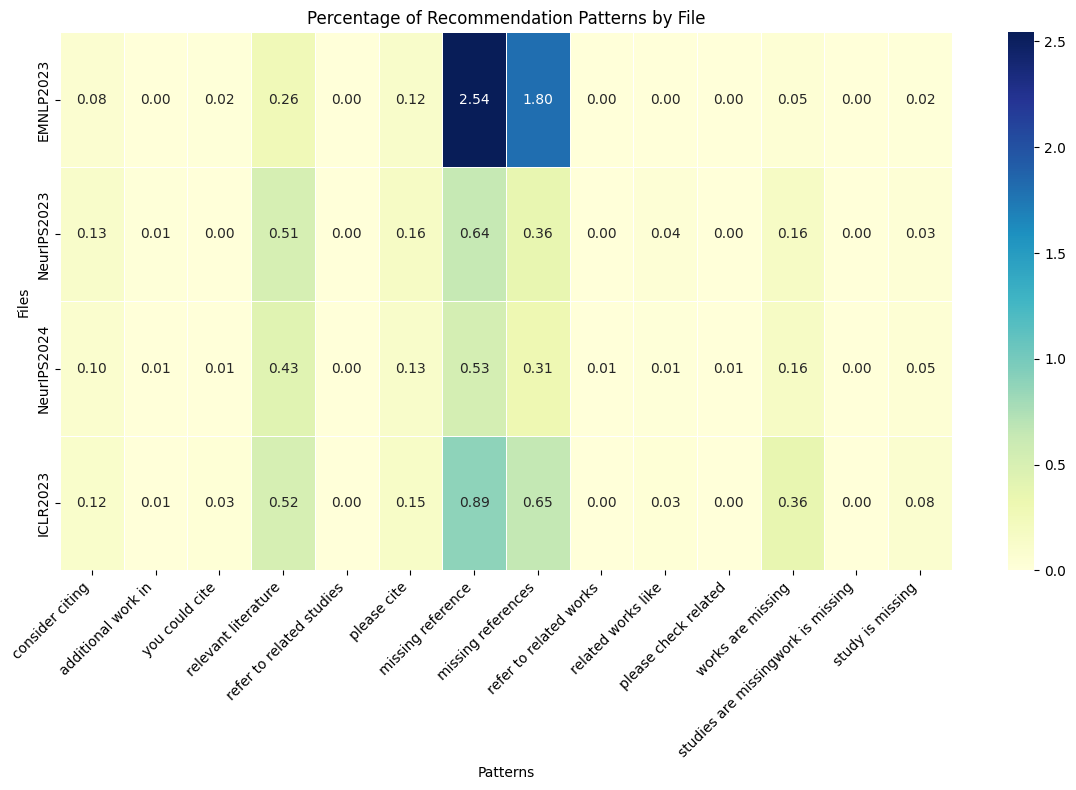

In [9]:
def load_reviews(file_paths):
    all_reviews = []
    for file_path in file_paths:
        with open(file_path, 'r') as file:
            data = json.load(file)
            all_reviews.extend(data)
    return all_reviews

# for data aquired from API2
def recommendation_patterns(content, patterns):
    recommendations = []
    for key, value in content.items():
        if isinstance(value, dict) and "value" in value:
            text = value["value"]
            if isinstance(text, str):  # ensure text is string
                for pattern in patterns:
                    if re.search(pattern, text,re.IGNORECASE):
                        recommendations.append((key, pattern))
    return recommendations

# for data aquired from API1
def recommendation_patterns_iclr2023(content, patterns):
    recommendations = []
    for key, value in content.items():
        if isinstance(value, str): # ensure text is string
            for pattern in patterns:
                if re.search(pattern, value, re.IGNORECASE):
                    recommendations.append((key, pattern))
    return recommendations

def analyze_reviews(reviews, patterns, file_name=None):
    detailed_results = []
    total_matches = 0

    if file_name and "ICLR2023" in file_name:
        recommendation_func = recommendation_patterns_iclr2023
    else:
        recommendation_func = recommendation_patterns

    total_reviews = len(reviews)

    for review in reviews:
        content = review.get("content", {})
        matches = recommendation_func(content, patterns)
        if matches:
            detailed_results.append({
                "review_id": review["id"],
                "matches": matches
            })
            total_matches += len(matches)

    # calculate the percentage of matches
    percentage_matches = (total_matches / total_reviews) * 100 if total_reviews > 0 else 0

    return total_matches, total_reviews, percentage_matches, detailed_results

def main():
    # key words for suggesting citing
    patterns = [
        r"consider citing",
        r"additional work in",
        r"you could cite",
        r"relevant literature",
        r"refer to related studies",
        r"please cite",
        r"missing reference",
        r"missing references",
        r"refer to related works",
        r"related works like",
        r"please check related",
        r"works are missing",
        r"studies are missing"
        r"work is missing",
        r"study is missing"
    ]

    file_paths = [
        "/content/drive/MyDrive/Thesis/EMNLP2023.json",
        "/content/drive/MyDrive/Thesis/NeurIPS2023.json",
        "/content/drive/MyDrive/Thesis/NeurIPS2024.json",
        "/content/drive/MyDrive/Thesis/ICLR2023.json"
    ]

    # analyze reviews individually
    results_by_file = {}
    for file_path in file_paths:
        clean_file_name = os.path.splitext(os.path.basename(file_path))[0]  #file name without path or extension
        print(f"\nAnalyzing file: {clean_file_name}")
        reviews_in_file = load_reviews([file_path])
        total_matches, total_reviews, percentage_matches, detailed_results = analyze_reviews(reviews_in_file, patterns, file_name=file_path)
        results_by_file[clean_file_name] = {
            "total_matches": total_matches,
            "total_reviews": total_reviews,
            "percentage_matches": percentage_matches,
            "detailed_results": detailed_results
        }
        print(f"Total matches found in {clean_file_name}: {total_matches} ({percentage_matches:.2f}% of reviews)")


    plot_total_matches(results_by_file)
    plot_heatmap(results_by_file, patterns)


    return results_by_file

if __name__ == "__main__":
    results_by_file = main()



Analyzing file: EMNLP2023
Total matches found in EMNLP2023: 860 (13.34% of reviews)

Analyzing file: NeurIPS2023
Total matches found in NeurIPS2023: 4585 (30.21% of reviews)

Analyzing file: NeurIPS2024
Total matches found in NeurIPS2024: 4946 (29.71% of reviews)

Analyzing file: ICLR2023
Total matches found in ICLR2023: 2649 (18.46% of reviews)


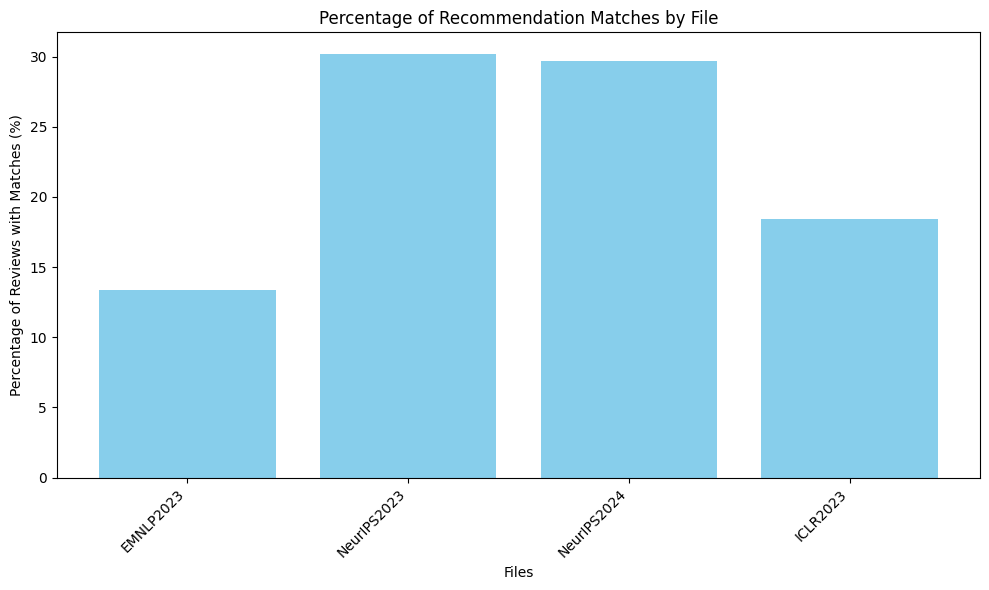

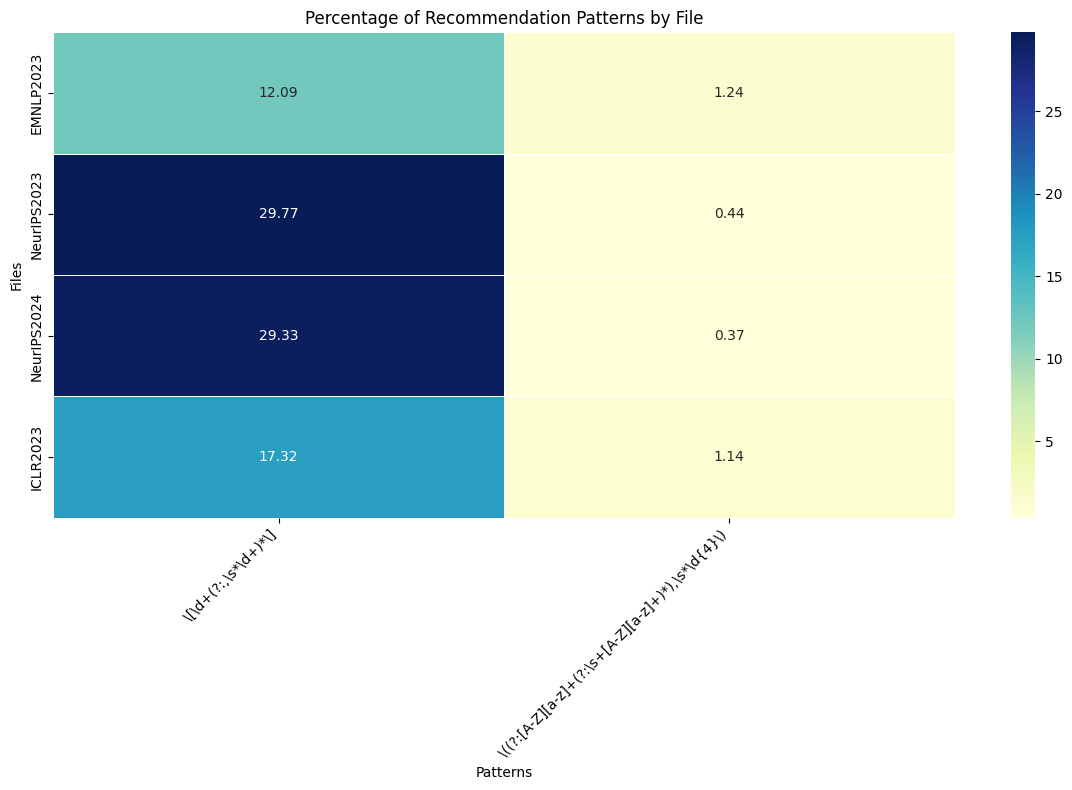

In [8]:
def main():
    # key patterns for suggesting citing
    patterns = [
        r"\[\d+(?:,\s*\d+)*\]",  # Matches [1], [1, 2], [1-3]
        r"\((?:[A-Z][a-z]+(?:\s+[A-Z][a-z]+)*),\s*\d{4}\)",  # Matches (Name, 2025), (Name and Name, 2025)
    ]

    file_paths = [
        "/content/drive/MyDrive/Thesis/EMNLP2023.json",
        "/content/drive/MyDrive/Thesis/NeurIPS2023.json",
        "/content/drive/MyDrive/Thesis/NeurIPS2024.json",
        "/content/drive/MyDrive/Thesis/ICLR2023.json"
    ]

    # analyze reviews individually
    results_by_file = {}
    for file_path in file_paths:
        clean_file_name = os.path.splitext(os.path.basename(file_path))[0]  #file name without path or extension
        print(f"\nAnalyzing file: {clean_file_name}")
        reviews_in_file = load_reviews([file_path])
        total_matches, total_reviews, percentage_matches, detailed_results = analyze_reviews(reviews_in_file, patterns, file_name=file_path)
        results_by_file[clean_file_name] = {
            "total_matches": total_matches,
            "total_reviews": total_reviews,
            "percentage_matches": percentage_matches,
            "detailed_results": detailed_results
        }
        print(f"Total matches found in {clean_file_name}: {total_matches} ({percentage_matches:.2f}% of reviews)")


    plot_total_matches(results_by_file)
    plot_heatmap(results_by_file, patterns)


    return results_by_file

if __name__ == "__main__":
    results_by_file = main()
